In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

Every instance of the dataset for supervised learning consist of two parts:

1. **Input features** are different values that are used to perform inference and make decisions. Initially these values might be represented by any data type, but before puting them into model, needs to be transformed into numerical formats.
$$
i \in \mathbb{R}^{\text{\# features}}
$$

2. **Targets** are the actual values that the model needs to predict, given the input.
$$
t \in \mathbb{R}^{\text{\# outputs}}
$$

For this assignment The single label classification Iris dataset will be used for numpy implementation test.

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

ModuleNotFoundError: No module named 'sklearn'

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Model
In the most basic overview ANN consist of multiple layers with same structure. These layers are defined with the parameters weights matrix $W$ and bias vector $b$. The structure of each layer looks as follows:

- **Fully connected** layer servers as main place of computation in the basic ANN.
$$
z^{(l)} = W^{(l)}a^{(l-1)} + b^{(l)}
$$
Where $W \in \mathbb{R}^{\text{\# inputs} \times \text{\# outputs}}$ and $b \in \mathbb{R}^{\text{\# outputs}}$ are learnable.

- **Activation function** is the next step after linear transformation. Activation function should be non-linear, since otherwise all the model will be just the composition of linear transformation, which is equivalent to single matrix multiplication, which is obviously not capable to cover some dependencies of the inputs.
Here the ReLu function will be used:

$$
a = \text{ReLU}(z)
$$

$$
\text{ReLU}(z) =
\begin{cases}
z, & \text{if } z > 0 \\
0, & \text{if } z \leq 0
\end{cases}
$$

- **Output layer** of the model depends on the task, for classification, the last layer should have number of nodes equal to number of classes in the dataset.
    After all the previous layers done, these nodes will take some raw numbers as the result of all previous computations, which are called logits.
    Since the task is classification, we want to get the probability distribution of every class given input $P(x = c | input), \quad \text{for }c = 1,2, \cdots, n $. The probability distribution should follow main rules:
  The probability distribution should follow main rules:

$$
1. \text{Non-negativity: } P(x) \geq 0, \quad \forall x
$$

$$
2. \text{Normalization: } \sum_x P(x) = 1 \quad \text{(discrete case)} \quad \text{or} \quad \int P(x) dx = 1 \quad \text{(continuous case)}
$$

In case of single label classification the softmax function is used to get the distribution from logits:
$$
\text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{i} e^{z_i}}
$$

For numerical stability, we also want to subtract $\text{max}{(z)}$ before applying softmax.

After all steps reviewed we could asemble the Model architecture, we will have 1 hidden layer and 3 output classes:

<img src="math/architecture.jpg" alt="Local Image" width="1000">


# Training

The key idea how the model train in the supervised approach requires few concepts that will be covered in this section.
The high level idea is to use actual target $y$ for given instance and predicted value $\hat y$ and compute $Loss(y,\hat y)$ some function that outputs measure of how good the model predicted this instance, then we could use calculus to compute how to change model parameters to minimize the Loss function.

## Cross-Entropy
Cross-Entropy is general idea that allows to numerically estimate how much two distributions align.

To build intuition about this concept, I like to introduce the idea of **surprise**:

1. We experience **more surprise** when we sample a **rare event** and **less surprise** when an event has a **high probability**. This suggests that surprise is **inversely proportional to probability**.
2. Additionally, if we sample a rare event **twice**, our surprise should **double**.

#### Formalizing Surprise

Suppose we define surprise as $s(x)$, and consider an event $x = a$ with probability:

$$
p(x = a) = 0.2
$$

If the surprise for this event is:

$$
s(x = a) = m
$$

Then, if we sample the same event twice:

$$
p(x = a \cap x = a) = 0.2^2 = 0.04
$$

The corresponding surprise should double:

$$
s(x = a \cap x = a) = 2m
$$

Since multiplication of probabilities corresponds to **addition of surprises**, a natural definition of surprise is:

$$
s(x) = \log \frac{1}{p(x)}
$$

Once we have the idea of surprise defined, we could move to the Entropy.

The value of Entropy might be seen as expected surprise measure of the distribution:

$$
H(P) = \mathbb {E}[log(\frac{1}{p})] = \sum_i{p_i \cdot \log \frac{1}{p_i}}
$$

Generally this value is not too big, since we kind of weight the surprise with probability and "know what to expect". When we know all the underlying distribution the computed surprise for every even is computed according to its actual probability.

This concept alone is not so powerful, but it allows us to introduce the tool that measures how good some Distribution $Q$ estimates the average surprise, when sampling from Distribution $P$, this is called Cross-Entropy.

## Cross-Entropy
Cross-Entropy is the function of 2 Probability Distributions that quantifies the expectation of surprise, when observing the random process generated from $P$ but believing it comes from $Q$.

$$
H(P,Q) = \sum_i{p_i \cdot \log \frac{1}{q_i}}
$$

When we consider the $H(P,P)$ it naturally equals to just entropy of $P$:

$$
H(P,P) = \sum_i{p_i \cdot \log \frac{1}{p_i}} = H(P)
$$

The key property that I won't be proving here is that:

$$
\forall Q,P : H(P) \leq H(P,Q)
$$

For any mode lthe Cross-Entropy can never be lower than the Entropy of the underlying distribution.

---
### Additional Notes
Also considering the topic of the Cross-Entropy I want to mention the idea of Kullback–Leibler Divergence, this idea allows to measure how much the $H(P,Q)$ differs from $H(P)$.

$$
H(P,Q) = \sum_i{p_i \cdot \log \frac{1}{q_i}}
$$

$$
H(P) = \sum_i{p_i \cdot \log \frac{1}{p_i}}
$$

Then the formula for KL Divergence looks as:

$$
\begin{align}
\mathcal{D}_{KL} &= H(P,Q) - H(P) = \\
    &= \sum_i{p_s(\log \frac{1}{q_i} - \log \frac{1}{p_i})} = \\
    &= \sum_i{p_s \log \frac{p_i}{q_i}}
\end{align}
$$

However, for our case it is not useful since:

$$
\mathcal{D}_{KL} = H(P,Q) - H(P)
$$

The P is underlaying distribution and it doesn't depend on the model parameters, so minimizing the $\mathcal{D}_{KL}$ is equivalent to $H(P,Q)$.



## Complete Loss Function

Now we have discussed all the concepts to set up the Loss Function for the training process, we could simply use the Cross-Entropy, but since we are dealing with single label classification, we could perform one step that will simplify future math derivations.

Firstly lets denote concreate variables we are going to use:

$$
\begin{aligned}
t &- \text{encoded value of actual class} \\
\hat{y} &- \text{vector of predicted probabilities for each class, where } \hat{y}_i = \text{probability of class } i
\end{aligned}
$$

Using these notation the formula for Loss will look as follows:

$$
Loss(t, \hat y) = \sum_s p_s \log {\frac{1}{\hat y_s}}
$$

In our case the $P$ is described with actual value $t$ in every sample, meaning we have $e_t(i) =
\begin{cases}
1, & \text{if } i = t \\
0, & \text{otherwise}
\end{cases}$, where $t$ is actual ground-truth and all other items are $0$.

So using this detailed the Loss function might be simplified to:

$$
Loss(t, \hat y) = \log {\frac{1}{\hat y_t}}
$$

To simplify future derivations, rewrite the log:

$$
Loss(t, \hat y) = - \log {\hat y_t}
$$

This means for each train sample to loss  is just the nagative logarithm of the target class probability. This formula is called Negative Log Likelihood which is final loss function for training process(not considering the regularization terms).

# A bit of Math

Now we could move to the derivation of model params in training process, the next step is to apply chain rule and find:

$$
\frac{\partial L}{\partial W^{(l)}},\frac{\partial L}{\partial b^{(l)}}, \quad \text{for each layer } l
$$

Since the Neural Network is just function of parameters $Loss = f(W, b)$, these partial derivatives shows how the change in the weight effect the value of loss, the gradient represents the vector of the fastest growth, since the optimization mostly consider minimization task, we will consider moving gradually changing the value of parameters in the opposite direction of the gradient.


## Chain Rule

To find the value of weights and bias, we need:

$$
\frac{\partial L}{\partial W^3} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z} \cdot \frac{\partial z}{\partial a_3} \cdot \frac{\partial a_3}{\partial W_3}
$$
$$
\frac{\partial L}{\partial b^3} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z} \cdot \frac{\partial z}{\partial a_3} \cdot \frac{\partial a_3}{\partial b_3}
$$

Firstly we want to compute value of $\frac{\partial L}{\partial z}$ so then we could directly move towards counting the actual gradient of model Params.

$$
\frac{\partial L}{\partial z} = \frac{\partial L}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial \hat z}
$$


## 1. $\frac{\partial L}{\partial \hat y}$

let's consider variables and function that are used at this step:

$$
\begin{aligned}
&t - \text{encoded value of actual class} \\
&\hat{y} - \text{vector of predicted probabilities for each class, where } \hat{y}_i = \text{probability of class } i \\
&\text{Loss}(t, \hat{y}) = -\log \hat{y}_t
\end{aligned}
$$

Then it is clear that:
$$
\frac{\partial L}{\partial \hat y} = \begin{cases}
-\frac{1}{\hat y_i}, & \text{if } i = t \\
0, & \text{otherwise}
\end{cases}
$$


## 2. $\frac{\partial \hat y}{\partial z}$

Now we need to find $\frac{\partial \hat y}{\partial z}$ how the result of softmax $\hat y$ depends on the input $z$(logits).

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum e^{z_j}}, \quad \text{for } i = 1,2, \dots, n
$$

where we consider two cases: $i = k$ and $i \neq k$.

Also lets denote the denominator as:
$$
D = \sum e^{z_j}
$$

Then the softmax formula looks:
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{D}, \quad \text{for } i = 1,2, \dots, n
$$

### 2.1 $ i = k$

$$
\begin{aligned}
\frac{\partial \hat y_i}{\partial z_i} &= \frac{D \cdot \frac{\partial}{\partial z_i}e^{z_i} - e^{z_i}\cdot \frac{\partial}{\partial z_i}D}{D^2} = \frac{D \cdot e^{z_i} - (e^{z_i})^2}{D^2} = \\
&= \frac{e^{z_i} \cdot (D - e^{z_i})}{D^2} = \frac{e^{z_i}}{D} \cdot \frac{D - e^{z_i}}{D} = \hat y_i \cdot (1 - \hat y_i)
\end{aligned}
$$

So for this case:
$$
\frac{\partial \hat y_i}{\partial z_i} = \hat y_i \cdot (1 - \hat y_i)
$$

### 2.2 $i \neq k$

$$
\begin{aligned}
\frac{\partial \hat y_i}{\partial z_k} &= \frac{D \cdot \frac{\partial}{\partial z_k}e^{z_i} - e^{z_i}\cdot \frac{\partial}{\partial z_k}D}{D^2} = \frac{- e^{z_i} \cdot e^{z_k}}{D^2} = \\
&= \frac{- e^{z_i}}{D} \cdot \frac{e^{z_k}}{D} = - \hat y_i \cdot \hat y_k
\end{aligned}
$$

For this case:
$$
\frac{\partial \hat y_i}{\partial z_k} = - \hat y_i \cdot \hat y_k
$$

After covering these 2 cases, we could write the general formula for Jacobian of $\frac{\partial \hat y_i}{\partial z_k}$:

$$
\begin{aligned}
&\frac{\partial \hat y_i}{\partial z_k} = \hat y_i \cdot (\delta_{ik} - \hat y_k) \\
&\text{Where: } \delta_{ik} - \text{Krocker delta, meanining } \begin{cases}
1, & \text{if } i = k \\
0, & \text{otherwise}
\end{cases}
\end{aligned}
$$





## 3. $\frac{\partial L}{\partial z}$

Now the final step to finish the back propagation of Loss function is to chain $\frac{\partial L}{\partial z} = \frac{\partial L}{\partial\hat y} \cdot \frac{\partial \hat y}{\partial z}$

to properly apply chain rule, will transpose ${\frac{\partial \hat y}{\partial \hat y}}^T$ to get row-vector, then:
$$
\frac{\partial L}{\partial z} = {\frac{\partial \hat y}{\partial \hat y}}^T \cdot \frac{\partial \hat y}{\partial z}
$$

Then the operation looks:

$$
\frac{\partial L}{\partial z} = \begin{bmatrix} \frac{\partial L}{\partial \hat y_1} & \frac{\partial L}{\partial \hat y_2} & \cdots & \frac{\partial L}{\partial \hat y_n} \end{bmatrix}  \begin{bmatrix}
\frac{\partial \hat y_1}{\partial \hat z_1} & \frac{\partial \hat y_1}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_1}{\partial \hat z_n} \\
\frac{\partial \hat y_2}{\partial \hat z_1} & \frac{\partial \hat y_2}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_2}{\partial \hat z_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial \hat y_n}{\partial \hat z_1} & \frac{\partial \hat y_n}{\partial \hat z_2} & \cdots & \frac{\partial \hat y_n}{\partial \hat z_n} \\
\end{bmatrix}
$$

then:
$$
\frac{\partial L}{\partial z_i} = \sum_j \frac{\partial L}{\partial \hat y_j} \cdot \frac{\partial \hat y_j}{\partial a_i}
$$

Since $\frac{\partial L}{\partial \hat y_j} = 0$ for every value of $j$ except the target class $j = t$:

$$
\frac{\partial L}{\partial z_i} = \frac{\partial L}{\partial \hat y_j} \cdot \frac{\partial \hat y_j}{\partial a_i} = - \frac{1}{\hat y_t} \cdot \hat y_t (\delta_{it} - \hat y_i) = \hat y_i - \delta_{it}
$$

Now we are finally done with derivating the output layer and got the result $\frac{\partial L}{\partial z} =  \hat y - e_t$, this means that the gradient that is going to be used in the fully connected layers, that come from the Loss is just subtracting $1$ from the probability of target class and keeping others without changes. In the next section I will cover how to find $\frac{\partial L}{\partial W}$ and  $\frac{\partial L}{\partial b}$ within layer and how to pass the gradient to previous layer.



## 4. $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$

We now move on to computing the gradients with respect to the parameters of the fully connected layer that produced the logits. Recall that the logits are obtained via a linear transformation:

$$
z = Wx + b
$$

where:
- $W$ is the weight matrix,
- $b$ is the bias vector,
- $x$ is the input vector to this layer.

We have already derived that the gradient of the loss with respect to the logits is:

$$
\frac{\partial L}{\partial z} = \hat{y} - e_t
$$

Here, $\hat{y}$ is the vector of predicted probabilities (the output of the softmax), and $e_t$ is the one-hot encoded vector of the true label.

### Gradient with Respect to $W$

Using the chain rule, the gradient of the loss with respect to $W$ is given by:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial W}
$$

Since the transformation is linear ($z = Wx + b$), the derivative of $z$ with respect to $W$ is straightforward. For each element $W_{ij}$ of the weight matrix, the corresponding element of $z$ satisfies:

$$
\frac{\partial z_i}{\partial W_{ij}} = x_j
$$

Thus, in matrix form, the full gradient with respect to $W$ is obtained by multiplying the column vector $\frac{\partial L}{\partial z}$ by the row vector $x^T$:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z} x^T = (\hat{y} - e_t) \, x^T
$$

This expression shows that each element of the gradient matrix $\frac{\partial L}{\partial W}$ is given by the product of the error term for that output and the corresponding input feature.

### Gradient with Respect to $b$

Similarly, for the bias vector $b$, we have:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial b}
$$

Because $z = Wx + b$ and the derivative of $z$ with respect to $b$ is 1 (for each component, since the bias is added directly), we obtain:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial z}
$$


## 5. $\frac{\partial L}{\partial x}$

Now, to propagate the gradient back to the previous layer, we need to compute the gradient of the loss with respect to the input $x$ of the current layer.

Recall that the logits are computed as:
$$
z = Wx + b
$$

We have already derived that:
$$
\frac{\partial L}{\partial z} = \hat{y} - e_t
$$

Using the chain rule, the gradient of the loss with respect to $x$ is given by:
$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x}
$$

Since $z = Wx + b$, the derivative $\frac{\partial z}{\partial x}$ is the weight matrix $W$. Taking dimensions into account, we obtain:
$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} W^T  = (\hat{y} - e_t) W^T
$$

This gradient, $\frac{\partial L}{\partial x}$, is then passed to the previous layer, allowing the network to propagate the error backward and update its parameters accordingly.


# Model

Now we finally have all the formulas and tools to train our model using Gradient Descent. We will now describe the process for a network with three layers. For simplicity, assume we have:

- **Layer 1:** First (input) layer
- **Layer 2:** Second (hidden) layer
- **Layer 3:** Output layer

---

### Forward Pass

The forward pass is executed as follows:

1. **Layer 1:**
   $$
   \begin{aligned}
   z^{(1)} &= W^{(1)} x + b^{(1)} \\
   a^{(1)} &= f^{(1)}(z^{(1)})
   \end{aligned}
   $$
   where $f^{(1)}$ is the activation function of Layer 1.

2. **Layer 2:**
   $$
   \begin{aligned}
   z^{(2)} &= W^{(2)} a^{(1)} + b^{(2)} \\
   a^{(2)} &= f^{(2)}(z^{(2)})
   \end{aligned}
   $$
   where $f^{(2)}$ is the activation function of Layer 2.

3. **Layer 3 (Output Layer):**
   $$
   \begin{aligned}
   z^{(3)} &= W^{(3)} a^{(2)} + b^{(3)} \\
   \hat{y} &= \text{softmax}(z^{(3)})
   \end{aligned}
   $$
   The predicted probabilities $\hat{y}$ are obtained by applying the softmax function to the logits $z^{(3)}$.

4. **Loss Computation:**
   The loss is computed using the true target $t$:
   $$
   L = -\log \hat{y}_t
   $$

---

### Backward Pass

The backward pass involves computing gradients for each layer, starting from the output and propagating backward.

1. **Output Layer (Layer 3):**

   - **Gradient with respect to logits:**
     $$
     \frac{\partial L}{\partial z^{(3)}} = \hat{y} - e_t
     $$

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(3)}} &= \frac{\partial L}{\partial z^{(3)}} \, (a^{(2)})^T \\
     \frac{\partial L}{\partial b^{(3)}} &= \frac{\partial L}{\partial z^{(3)}}
     \end{aligned}
     $$

   - **Gradient to propagate to Layer 2:**
     $$
     \frac{\partial L}{\partial a^{(2)}} = \left(W^{(3)}\right)^T \frac{\partial L}{\partial z^{(3)}}
     $$

2. **Second Layer (Layer 2):**

   - **Gradient with respect to pre-activation:**
     Apply the derivative of the activation function $f^{(2)}$ (denoted by $f'^{(2)}$):
     $$
     \frac{\partial L}{\partial z^{(2)}} = \frac{\partial L}{\partial a^{(2)}} \odot f'^{(2)}(z^{(2)})
     $$
     where $\odot$ denotes Hadamard Product multiplication.

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(2)}} &= \frac{\partial L}{\partial z^{(2)}} \, (a^{(1)})^T \\
     \frac{\partial L}{\partial b^{(2)}} &= \frac{\partial L}{\partial z^{(2)}}
     \end{aligned}
     $$

   - **Gradient to propagate to Layer 1:**
     $$
     \frac{\partial L}{\partial a^{(1)}} = \left(W^{(2)}\right)^T \frac{\partial L}{\partial z^{(2)}}
     $$

3. **First Layer (Layer 1):**

   - **Gradient with respect to pre-activation:**
     Similarly, apply the derivative of $f^{(1)}$:
     $$
     \frac{\partial L}{\partial z^{(1)}} = \frac{\partial L}{\partial a^{(1)}} \odot f'^{(1)}(z^{(1)})
     $$

   - **Gradients for parameters:**
     $$
     \begin{aligned}
     \frac{\partial L}{\partial W^{(1)}} &= \frac{\partial L}{\partial z^{(1)}} \, x^T \\
     \frac{\partial L}{\partial b^{(1)}} &= \frac{\partial L}{\partial z^{(1)}}
     \end{aligned}
     $$

---

### Parameter Update

After computing all the gradients, the network parameters are updated using Gradient Descent. For each layer $l$ (where $l = 1,2,3$):

$$
\begin{aligned}
W^{(l)} &\leftarrow W^{(l)} - \alpha \, \frac{\partial L}{\partial W^{(l)}} \\
b^{(l)} &\leftarrow b^{(l)} - \alpha \, \frac{\partial L}{\partial b^{(l)}}
\end{aligned}
$$

Where, $\alpha$ is the learning rate.


### Now lets finally do some coding)

In [4]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Next step is to convert the dataframe into ndarray and init the data loader class

In [5]:
data = df.values

In [6]:
x = data[:, :-1]
y = data[:, -1]

indices = np.arange(x.shape[0])
np.random.shuffle(indices)

x, y = x[indices], y[indices]

train_ratio = 0.8
split_idx = int(x.shape[0] * train_ratio)

x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [7]:
class DataLoaderLocal:
    def __init__(self, x, y, batch_size=32):
        self.x = x
        self.y = y.astype(int)
        self.batch_size = batch_size
        self.num_samples = x.shape[0]
        self.indices = np.arange(self.num_samples)

    def __iter__(self):
        np.random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= self.num_samples:
            raise StopIteration
        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices].astype(int)
        self.current_index += self.batch_size
        return batch_x, batch_y

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))


In [8]:
train_loader = DataLoaderLocal(x_train, y_train, batch_size=32)
test_loader = DataLoaderLocal(x_test, y_test, batch_size=32)

## Numpy Implementation

Firstly The model is implemented in numpy, primary to test if all the formulas from math block are correct. The next section I will also implement the model using pyTorch.

I will start implementation by defining all necesary layers and helper functions that are required to build the model.

In [9]:
def softmax(predictions):
    '''
    Computes probabilities from scores

    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output

    Returns:
      probs, np array of the same shape as predictions -
        probability for every class, 0..1
    '''

    if predictions.ndim == 1:
        predictions -= np.max(predictions)
    else:
        predictions -= np.max(predictions, axis=1, keepdims=True)

    exponents = np.exp(predictions)

    if predictions.ndim == 1:
        sum = np.sum(exponents)
    else:
        sum = np.sum(exponents, axis=1, keepdims=True)

    probs = exponents / sum

    return probs


def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss

    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: int or np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)

    Returns:
      loss: single value
    '''
    if probs.ndim == 1:
        loss = -np.log(probs[target_index])
    else:
        batch_size = probs.shape[0]
        correct_logprobs = -np.log(probs[np.arange(batch_size), target_index])
        loss = np.mean(correct_logprobs)
    return loss


def softmax_with_cross_entropy(preds, target_index):
    predictions_c = preds.copy()
    predictions_c = softmax(predictions_c)
    loss = cross_entropy_loss(predictions_c, target_index)
    dprediction = predictions_c.copy()

    if predictions_c.ndim == 1:
        dprediction[target_index] -= 1
    else:
        batch_size = predictions_c.shape[0]
        dprediction[np.arange(batch_size), target_index.ravel()] -= 1
        dprediction /= batch_size

    return loss, dprediction


class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)


class ReLULayer:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = (X > 0).astype(int)  # mask for values > 0
        return np.maximum(X, 0)

    def backward(self, d_out):
        """
        Backward pass

        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """

        d_result = d_out * self.mask

        return d_result

    def params(self):
        return {}


class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(np.sqrt(2.0 / n_input) * np.random.randn(n_input, n_output))
        self.B = Param(np.zeros((1, n_output)))
        self.X = None

    def forward(self, X):
        self.X = X  # Save input for backward pass.
        res = X @ self.W.value + self.B.value
        return res

    def backward(self, d_out):
        # Compute gradient with respect to input.
        d_input = d_out @ self.W.value.T

        # Compute gradients for weights and biases.
        d_W = self.X.T @ d_out
        self.W.grad += d_W

        d_B = np.sum(d_out, axis=0, keepdims=True)
        self.B.grad += d_B

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import torch

def eval_model(model, test_loader, classes=None, py_torch=False):
    """
    Evaluates a given model on a test set, printing key metrics and
    plotting a confusion matrix. You can pass an optional list of class
    names to label the axes of the confusion matrix.

    Parameters
    ----------
    model : nn.Module or similar
        The trained model to evaluate.
    test_loader : DataLoader
        A PyTorch DataLoader providing test batches (x, y).
    classes : list of str, optional
        List of class names for labeling the confusion matrix.
        If None, numeric labels are used.
    py_torch : bool, optional
        Indicates whether the model is a PyTorch model. If False,
        the model is assumed to be a NumPy-based model.
    Returns
    -------
    None
        Prints out accuracy, precision, recall, F1 score, classification
        report, and displays a confusion matrix heatmap.
    """
    if py_torch:
        model.eval()

    all_y_true = []
    all_y_pred = []

    # Iterate over the test set
    for x, y in test_loader:
        if py_torch:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

        # Forward pass
        y_hat = model.forward(x)

        if py_torch:
            # Move predictions and labels to CPU for metric computation
            preds = torch.argmax(y_hat, dim=1).detach().cpu().numpy()
            y = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        else:
            preds = np.argmax(y_hat, axis=1)

        all_y_true.extend(y.astype(int))
        all_y_pred.extend(preds.astype(int))

    # Convert to NumPy arrays
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    recall = recall_score(all_y_true, all_y_pred, average='weighted', zero_division=0)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted', zero_division=0)

    # Print key metrics
    print("\n\033[1mEvaluation Metrics:\033[0m")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Classification report
    print("\n\033[1mClassification Report:\033[0m")
    print(classification_report(all_y_true, all_y_pred, zero_division=0))

    # Confusion matrix and heatmap
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes if classes else None,
        yticklabels=classes if classes else None
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

Now once all the building blocks are defined, I will create the model class, wich will take the layers as the paremeters and allow to build diferent simple rchitectures by stacking and modifying fully conected layers.

In [10]:
class Model:
    def __init__(self, layers):
        """
        Initialize the model with a list of layers.
        """
        self.layers = layers

    def forward(self, x):
        """
        Perform a forward pass through all layers.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss_and_grad(self, predictions, target_index):
        """
        Compute the softmax with cross entropy loss and return both the loss
        and the gradient.
        """
        loss, grad = softmax_with_cross_entropy(predictions, target_index)
        return loss, grad

    def backward(self, grad):
        """
        Backpropagate the gradient through all layers.
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params(self):
        """
        Collects parameters from all layers.
        Returns a dictionary mapping layer names to their parameters.
        """
        parameters = {}
        for idx, layer in enumerate(self.layers):
            for name, param in layer.params().items():
                parameters[f"layer{idx}_{name}"] = param
        return parameters

    def update_params(self, lr):
        """
        Updates all parameters.
        """
        for param in self.params().values():
            param.value -= lr * param.grad
            param.grad = np.zeros_like(param.grad)

    def train(self, lr, epochs, data_loader):
        """
        Trains the model.
        data_loader should yield batches as (x, y) where:
          - x is input with shape (batch_size, input_size)
          - y contains the target class indices for each sample.
        """
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            for x, y in data_loader:
                # Forward pass: compute predictions for the current batch.
                predictions = self.forward(x)

                # Compute loss and gradient at the output.
                loss, grad = self.compute_loss_and_grad(predictions, y)
                epoch_loss += loss

                # Backward pass: propagate gradients through the network.
                self.backward(grad)

                # Update all parameters using gradient descent.
                self.update_params(lr)

            avg_loss = epoch_loss / len(data_loader)
            loss_list.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

        # Plot training loss.
        plt.plot(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

In [11]:
layers = [
    FullyConnectedLayer(4, 12),
    ReLULayer(),
    FullyConnectedLayer(12, 12),
    ReLULayer(),
    FullyConnectedLayer(12, 3)
]

model_numpy = Model(layers)

Epoch 1/300, Loss: 0.6555
Epoch 2/300, Loss: 0.6110
Epoch 3/300, Loss: 0.5903
Epoch 4/300, Loss: 0.5755
Epoch 5/300, Loss: 0.5630
Epoch 6/300, Loss: 0.5555
Epoch 7/300, Loss: 0.5472
Epoch 8/300, Loss: 0.5365
Epoch 9/300, Loss: 0.5345
Epoch 10/300, Loss: 0.5315
Epoch 11/300, Loss: 0.5231
Epoch 12/300, Loss: 0.5216
Epoch 13/300, Loss: 0.5131
Epoch 14/300, Loss: 0.5109
Epoch 15/300, Loss: 0.5069
Epoch 16/300, Loss: 0.4910
Epoch 17/300, Loss: 0.4854
Epoch 18/300, Loss: 0.4785
Epoch 19/300, Loss: 0.4701
Epoch 20/300, Loss: 0.4609
Epoch 21/300, Loss: 0.4563
Epoch 22/300, Loss: 0.4577
Epoch 23/300, Loss: 0.4446
Epoch 24/300, Loss: 0.4381
Epoch 25/300, Loss: 0.4368
Epoch 26/300, Loss: 0.4328
Epoch 27/300, Loss: 0.4319
Epoch 28/300, Loss: 0.4311
Epoch 29/300, Loss: 0.4229
Epoch 30/300, Loss: 0.4199
Epoch 31/300, Loss: 0.4155
Epoch 32/300, Loss: 0.4186
Epoch 33/300, Loss: 0.4105
Epoch 34/300, Loss: 0.4120
Epoch 35/300, Loss: 0.4133
Epoch 36/300, Loss: 0.4026
Epoch 37/300, Loss: 0.4021
Epoch 38/3

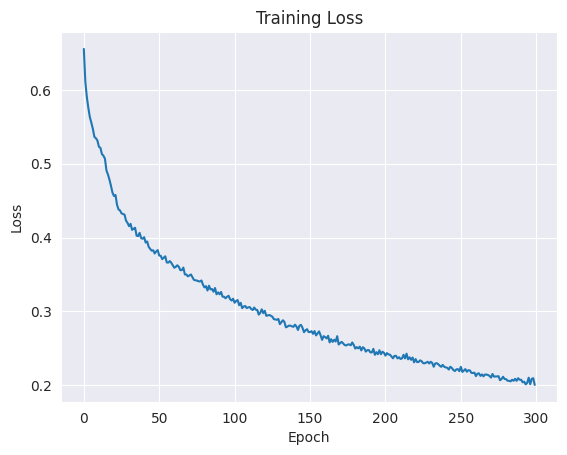

In [12]:
model_numpy.train(lr=0.001, epochs=300, data_loader=train_loader)

# Evaluation


Evaluation Metrics:
Accuracy:  0.9333
Precision: 0.9467
Recall:    0.9333
F1 Score:  0.9343

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.85      0.92        13
           2       0.80      1.00      0.89         8

    accuracy                           0.93        30
   macro avg       0.93      0.95      0.94        30
weighted avg       0.95      0.93      0.93        30



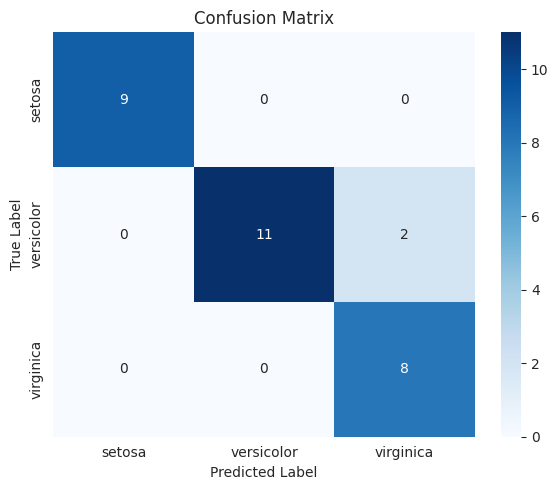

In [13]:
eval_model(model_numpy, test_loader, classes = iris.target_names.tolist())


### Basic Results and Analysis

The Iris dataset is small and easy to predict, which allows the model to quickly converge to a local minimum. The metrics show excellent overall performance with perfect results for class 0, and only minor misclassifications between classes 1 and 2.

The high accuracy and balanced precision/recall confirm that our manual NumPy implementation correctly handles the core computations. This experiment primarily tests our mathematical derivations and serves as a proof-of-concept. In the next phase, I'll use a larger dataset and a PyTorch model to explore different training strategies and hyperparameter tuning.

## PyTorch Training

For the bigger model implemented witt PyTorch I will use the CIFAR dataset and project each pixel value into the $\mathbb R^1$.

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [38]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dataset.dtype = torch.float32

batch_size = 512

train_loader_cifar = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader_cifar = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

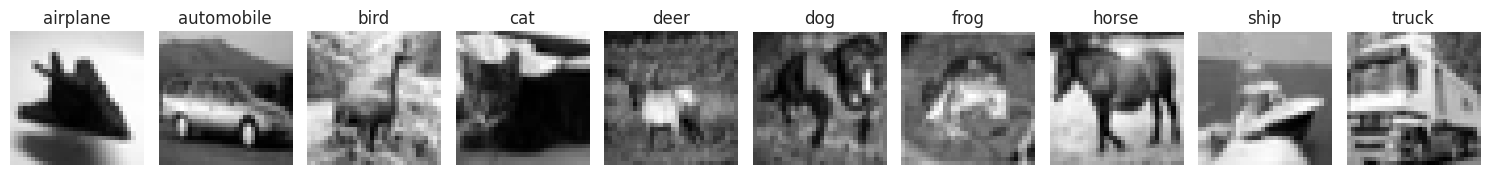

In [39]:
classes = train_dataset.classes

samples = {}
for img, label in train_dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == len(classes):
        break

# Plot the images.
fig, axs = plt.subplots(1, len(classes), figsize=(15, 4))
for label, ax in enumerate(axs):
    img_np = samples[label].squeeze().numpy()
    ax.imshow(img_np, cmap='gray')
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


### Visualization of Grayscale CIFAR-10 Samples

This cell visualizes a few sample images for each class from the CIFAR-10 dataset. Here, I apply a transformation to convert the original 3-channel color images into grayscale (1 channel).

**About the CIFAR-10 Dataset:**
- **Size:** 60,000 images (32x32 pixels) across 10 classes.
- **Classes:** Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, and Truck.
- **Usage:** Widely used for benchmarking in computer vision tasks.
- **Transformation:** In this example, I convert images to grayscale to simplify the input for basic ANN

In [40]:
class BasicANNPyTorch(nn.Module):
    def __init__(self):
        super(BasicANNPyTorch, self).__init__()
        # Input: 32x32 = 784 features
        self.fc1 = nn.Linear(32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In this notebook, we'll train a basic fully connected neural network on the CIFAR dataset. We will experiment with different learning rates, optimizers (Adam, SGD, RMSprop), and learning rate schedulers (none, StepLR, ReduceLROnPlateau).

 The goal is to compare the training loss and test accuracy under these different settings.

In [41]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, scheduler=None, device='cuda'):
    model.to(device)
    train_losses = []
    test_accuracies = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        # Scheduler step: for ReduceLROnPlateau, step using test loss; else, step normally.
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()

        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f} - Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

## Understanding Optimizer Algorithms

Also, it is important to understand how exactly optimizer algorithms work.

So initially, some problems with numerical methods exist:

Imagine the case when, in some local region of the loss function, the landscape is steep. Then the small learning rate might slow down the training process.

And vice versa, when we meet some regions with multiple local minimums or saddle points, we want the optimizer to adjust the learning rate to navigate the loss function landscape more precisely.

The high-level intuition is **driving a car**:
- When we are on a highway (which is equivalent to a steep region), we want to **increase speed**.
- In a city with lots of turns, we want to **decrease it**.

---

## Momentum in Gradient Descent Optimization

During the training process, it is possible to manage the update rule using different heuristics, that have proven their efficency allowing faster convergence and increased overall accuracy, by avoiding some local minima.

### Velocity and Update Rule

Firstly, it is important to start with a more general concept in gradient descent optimization: **momentum**.

The idea is to introduce so-called **velocity**, which changes the update rule:

$$
W \leftarrow v
$$

where velocity is defined as:

$$
v_{t+1} = \rho v_t - \alpha \nabla W
$$

where:
- $\rho$ is the hyperparameter that characterizes the resistance of velocity — how much we keep it between updates.
- $\alpha$ is the learning rate.


### Impact of Speed in Training

From this sketch, we can see how exactly speed makes the training process more stable, increasing speed while avoiding overshooting local minimums.

However, this method still has a problem:
- The gradient on the parameters is computed separately from the velocity jump.
- The gradient itself might not be appropriate in the point after adding velocity.

Actually, later, a student of Polyak introduced an improved momentum rule:

$$
W \leftarrow v
$$

$$
v_{t+1} = \rho v_t - \alpha \nabla (W_t + \rho v_t)
$$

Now, the gradient is computed at the exact point in the W spac, where the velocity jump is going to result.

---

### RMSprop and Adam Optimizers

With this covered, we can now move to the actual optimization algorithms that we are going to use.

While momentum helps to accelerate gradient descent in relevant directions, it does not address another major issue: adaptive learning rates. Some parameters require larger steps, while others should be updated **more cautiously.

A potential solution is **RMSprop (Root Mean Square Propagation)**, which adapts the learning rate based on past gradients.

## RMSprop: Adaptive Learning Rate with Moving Averages

RMSprop modifies the standard gradient descent rule by introducing an **adaptive step size** for each parameter, reducing oscillations and improving stability.

RMSprop keeps an exponentially decaying average of squared gradients:

$$
S_{t+1} = \beta S_t + (1 - \beta) (\nabla W_t)^2
$$

where:
- $S_t$ stores the moving average of squared gradients,
- $\beta$ is the decay rate, typically $0.9$,
- $\nabla W_t$ is the gradient at time step $t$.

The weight update rule is then modified as:

$$
W_{t+1} = W_t - \frac{\alpha}{\epsilon + \sqrt{S_{t+1}}} \nabla W_t
$$

where:
- $\alpha$ is the learning rate,
- $\epsilon$ is a small stabilization term (e.g., $10^{-8}$) to avoid division by zero.

### Intuition

- Prevents extreme fluctuations in learning by scaling updates based on their past magnitude.
- Reduces step size for large gradients and increases step size for small gradients.

However, RMSprop does not incorporate momentum directly, which leads to the introduction of **Adam**.

---

## Adam (Adaptive Moment Estimation)

Adam combines the benefits of momentum and RMSprop by maintaining two moving averages:

1. Momentum-like first moment estimate (mean of past gradients)
2. RMSprop-like second moment estimate (mean of past squared gradients)

The first moment estimate:

$$
m_{t+1} = \beta_1 m_t + (1 - \beta_1) \nabla W_t
$$

The second moment estimate:

$$
v_{t+1} = \beta_2 v_t + (1 - \beta_2) (\nabla W_t)^2
$$

where:
- $m_t$ is the moving average of gradients (similar to momentum),
- $v_t$ is the moving average of squared gradients (similar to RMSprop),
- $\beta_1$ and $\beta_2$ are decay rates, typically $\beta_1 = 0.9$, $\beta_2 = 0.999$.

Since both moving averages start at zero, they are biased toward zero in early iterations. To counteract this, Adam applies bias correction:

$$
\hat{m}_{t+1} = \frac{m_{t+1}}{1 - \beta_1^{t+1}}
$$

$$
\hat{v}_{t+1} = \frac{v_{t+1}}{1 - \beta_2^{t+1}}
$$

Finally, the update step:

$$
W_{t+1} = W_t - \frac{\alpha}{\sqrt{\hat{v}_{t+1}} + \epsilon} \hat{m}_{t+1}
$$

where $\hat{m}$ and $$\hat{v}$$ are the bias-corrected first and second moments.


### Intuition

- **Momentum Effect**: The update is influenced by past gradients, making it more stable.
- **Adaptive Learning Rate**: Steps become smaller for frequently updated parameters and larger for less frequently updated ones.
- **Faster Convergence**: Works well in most deep learning applications, making it a default choice for many tasks.

## Experiment Configurations

We define a list of configurations to experiment with:
- Different optimizers: Adam, SGD, RMSprop.
- Different learning rates: 0.001, 0.01, 0.0001.
- Different schedulers: None, StepLR, and ReduceLROnPlateau.

In [42]:
device = torch.device("cuda")

experiment_configs = [
    {"name": "Adam_lr_0.001_no_scheduler", "optimizer": "Adam", "lr": 0.001, "scheduler": None},
    {"name": "SGD_lr_0.001_no_scheduler", "optimizer": "SGD", "lr": 0.001, "scheduler": None},
    {"name": "RMSprop_lr_0.001_no_scheduler", "optimizer": "RMSprop", "lr": 0.001, "scheduler": None},
    {"name": "Adam_lr_0.001_StepLR", "optimizer": "Adam", "lr": 0.001, "scheduler": "StepLR"},
    {"name": "Adam_lr_0.001_ReduceLROnPlateau", "optimizer": "Adam", "lr": 0.001, "scheduler": "ReduceLROnPlateau"},
    {"name": "Adam_lr_0.01_no_scheduler", "optimizer": "Adam", "lr": 0.01, "scheduler": None},
    {"name": "Adam_lr_0.0001_no_scheduler", "optimizer": "Adam", "lr": 0.0001, "scheduler": None}
]

In [43]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()

results = {}

for config in experiment_configs:
    print("\n=== Running experiment:", config["name"], "===")

    # Initialize a new model for each experiment
    model_exp = BasicANNPyTorch().to(device)

    # Select optimizer based on config
    if config["optimizer"] == "Adam":
        opt = optim.Adam(model_exp.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        opt = optim.SGD(model_exp.parameters(), lr=config["lr"])
    elif config["optimizer"] == "RMSprop":
        opt = optim.RMSprop(model_exp.parameters(), lr=config["lr"])
    else:
        opt = optim.Adam(model_exp.parameters(), lr=config["lr"])

    # Set scheduler if specified
    if config["scheduler"] == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
    elif config["scheduler"] == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2, verbose=True)
    else:
        scheduler = None

    train_loss, test_acc = train_model(model_exp, train_loader_cifar, test_loader_cifar,
                                       criterion, opt, num_epochs, scheduler, "cuda")

    results[config["name"]] = {"train_loss": train_loss, "test_acc": test_acc}



=== Running experiment: Adam_lr_0.001_no_scheduler ===
Epoch 1/10 - Loss: 2.0484 - Test Accuracy: 31.56%
Epoch 2/10 - Loss: 1.8774 - Test Accuracy: 34.25%
Epoch 3/10 - Loss: 1.8086 - Test Accuracy: 36.51%
Epoch 4/10 - Loss: 1.7548 - Test Accuracy: 37.74%
Epoch 5/10 - Loss: 1.7046 - Test Accuracy: 39.35%
Epoch 6/10 - Loss: 1.6644 - Test Accuracy: 40.28%
Epoch 7/10 - Loss: 1.6248 - Test Accuracy: 40.73%
Epoch 8/10 - Loss: 1.5899 - Test Accuracy: 40.88%
Epoch 9/10 - Loss: 1.5582 - Test Accuracy: 41.17%
Epoch 10/10 - Loss: 1.5253 - Test Accuracy: 42.35%

=== Running experiment: SGD_lr_0.001_no_scheduler ===
Epoch 1/10 - Loss: 2.3035 - Test Accuracy: 12.45%
Epoch 2/10 - Loss: 2.2917 - Test Accuracy: 14.19%
Epoch 3/10 - Loss: 2.2832 - Test Accuracy: 15.87%
Epoch 4/10 - Loss: 2.2758 - Test Accuracy: 16.94%
Epoch 5/10 - Loss: 2.2686 - Test Accuracy: 17.36%
Epoch 6/10 - Loss: 2.2618 - Test Accuracy: 18.02%
Epoch 7/10 - Loss: 2.2550 - Test Accuracy: 18.75%
Epoch 8/10 - Loss: 2.2483 - Test Accur

/home/may33/projects/ml_portfolio/AIA/ann/venv/lib64/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Loss: 2.0263 - Test Accuracy: 30.95%
Epoch 2/10 - Loss: 1.8669 - Test Accuracy: 34.27%
Epoch 3/10 - Loss: 1.7995 - Test Accuracy: 35.40%
Epoch 4/10 - Loss: 1.7450 - Test Accuracy: 36.43%
Epoch 5/10 - Loss: 1.6973 - Test Accuracy: 39.23%
Epoch 6/10 - Loss: 1.6519 - Test Accuracy: 39.33%
Epoch 7/10 - Loss: 1.6103 - Test Accuracy: 41.14%
Epoch 8/10 - Loss: 1.5811 - Test Accuracy: 41.65%
Epoch 9/10 - Loss: 1.5521 - Test Accuracy: 42.90%
Epoch 10/10 - Loss: 1.5146 - Test Accuracy: 41.52%

=== Running experiment: Adam_lr_0.01_no_scheduler ===
Epoch 1/10 - Loss: 2.3574 - Test Accuracy: 27.55%
Epoch 2/10 - Loss: 1.9555 - Test Accuracy: 31.12%
Epoch 3/10 - Loss: 1.8919 - Test Accuracy: 32.34%
Epoch 4/10 - Loss: 1.8561 - Test Accuracy: 34.60%
Epoch 5/10 - Loss: 1.8337 - Test Accuracy: 33.96%
Epoch 6/10 - Loss: 1.8072 - Test Accuracy: 35.18%
Epoch 7/10 - Loss: 1.7932 - Test Accuracy: 35.38%
Epoch 8/10 - Loss: 1.7735 - Test Accuracy: 35.62%
Epoch 9/10 - Loss: 1.7624 - Test Accuracy: 3

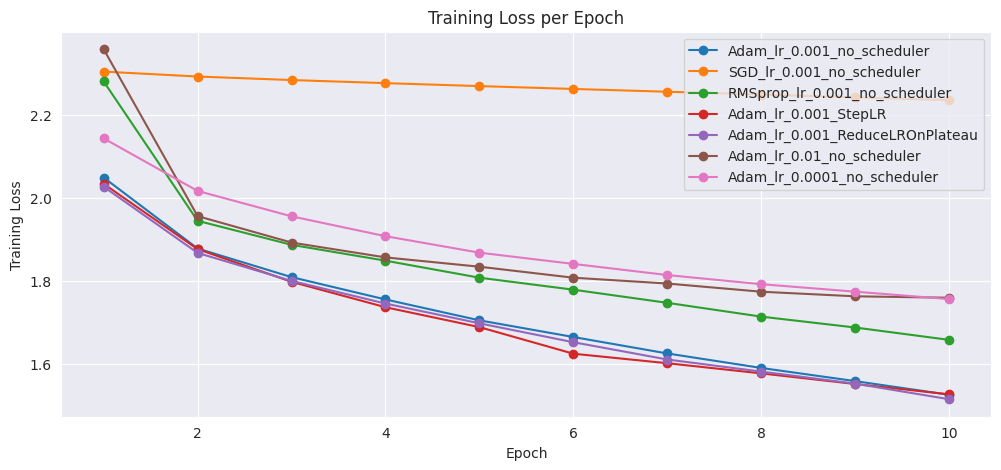

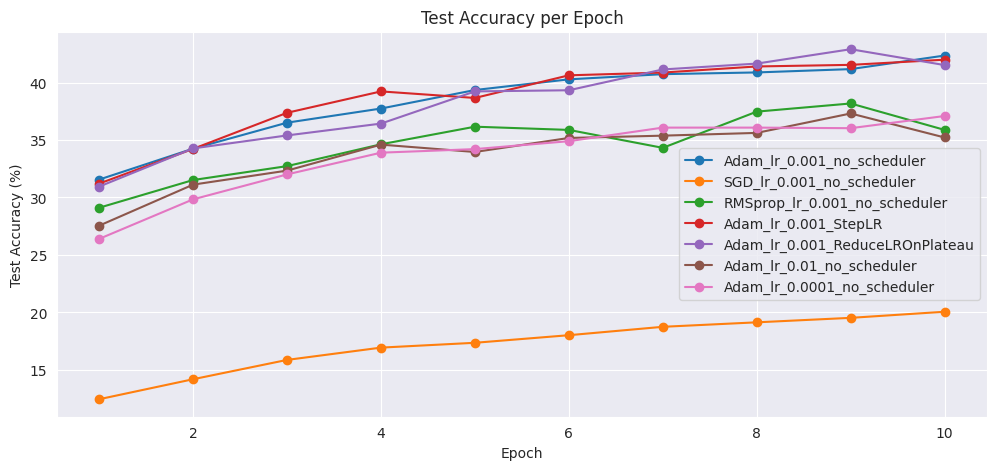

In [44]:
plt.figure(figsize=(12, 5))
for name, data in results.items():
    plt.plot(range(1, num_epochs + 1), data["train_loss"], marker='o', label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for name, data in results.items():
    plt.plot(range(1, num_epochs + 1), data["test_acc"], marker='o', label=name)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.legend()
plt.show()

### Results

Looking across the training loss and test accuracy curves, several clear trends emerge. Among the various optimizer and scheduler configurations, **Adam with StepLR (lr=0.001)** stands out as having the most effective and stable training. Early in the process, the learning rate is high enough to ensure significant improvements in the loss, and once the scheduler steps the learning rate down, the model consolidates those gains to achieve some of the highest test accuracy values.

**Adam (lr=0.001, no scheduler)** also shows strong performance—very close to the StepLR run—but lacks the additional fine-tuning provided by the scheduled reduction in learning rate. The adaptive nature of Adam still helps drive the loss down over the epochs, and the final accuracy is quite competitive.

**RMSprop (lr=0.001, no scheduler)** comes in just behind Adam. This optimizer similarly adapts its parameter-specific learning rates, which leads to solid improvements in both training loss and test accuracy. Although it doesn’t quite match Adam’s final performance, RMSprop’s results confirm the general advantage of adaptive optimizers over vanilla SGD at this learning rate.

Meanwhile, **Adam (lr=0.001, ReduceLROnPlateau)** ends up performing similarly to Adam without any scheduling. In this particular training run, the reduction in loss never stalled long enough to trigger the scheduler’s learning rate reduction, so its behavior resembled having no scheduler at all. Under different conditions—especially if the loss plateaued more distinctly—this scheduler might prove more useful.

With **Adam (lr=0.0001, no scheduler)**, the network continues to learn consistently but more slowly, as expected from a smaller step size. While it shows a gentle and steady decrease in training loss, the final test accuracy remains a little lower than with the moderate learning rate. This underscores how a very low learning rate can limit the final outcome even if it remains stable.

In sharp contrast, **SGD (lr=0.001, no scheduler)** struggles to keep pace with adaptive optimizers. Its lack of parameter-specific adjustments contributes to a slower drop in loss and less impressive test accuracy. Over more epochs or with additional refinements (e.g., momentum), SGD might close that gap, but in this short run it clearly lags behind.

Finally, **Adam (lr=0.01, no scheduler)** illustrates the pitfalls of an overly large learning rate. The model’s loss tends to fluctuate more than converge, and the test accuracy hovers well below the best-performing configurations. This pattern strongly suggests that the optimizer is overshooting during parameter updates and failing to settle in a suitable minimum.

Overall, the experiments confirm that moderate learning rates (around 0.001) with adaptive optimizers are a good baseline choice, and that scheduling those optimizers—particularly with StepLR—can deliver improved and more consistent results. The higher and lower learning rates show how pushing the parameter updates either too aggressively or too conservatively can hamper final model accuracy.


### Final Model Training with the Best Configuration

After a brief evaluation of multiple optimizers and schedulers, the configuration using **Adam with a learning rate of 0.001 and a StepLR scheduler** provided the best balance of stable convergence and final performance. Below is the code to train a final model with this setup, followed by an evaluation of its results.


In [45]:
class BigerANNPyTorch(nn.Module):
    def __init__(self):
        super(BigerANNPyTorch, self).__init__()
        # Input: 32x32 = 784 features
        self.fc1 = nn.Linear(32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [47]:
num_epochs = 20

criterion = nn.CrossEntropyLoss()

model = BigerANNPyTorch().to(device)

opt = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.2)

train_loss, test_acc = train_model(model, train_loader_cifar, test_loader_cifar,
                                   criterion, opt, num_epochs, scheduler, device)

Epoch 1/20 - Loss: 2.0035 - Test Accuracy: 33.72%
Epoch 2/20 - Loss: 1.8348 - Test Accuracy: 35.56%
Epoch 3/20 - Loss: 1.7487 - Test Accuracy: 37.99%
Epoch 4/20 - Loss: 1.6728 - Test Accuracy: 39.39%
Epoch 5/20 - Loss: 1.6223 - Test Accuracy: 41.21%
Epoch 6/20 - Loss: 1.5086 - Test Accuracy: 43.70%
Epoch 7/20 - Loss: 1.4722 - Test Accuracy: 43.37%
Epoch 8/20 - Loss: 1.4476 - Test Accuracy: 43.55%
Epoch 9/20 - Loss: 1.4275 - Test Accuracy: 44.34%
Epoch 10/20 - Loss: 1.4015 - Test Accuracy: 44.62%
Epoch 11/20 - Loss: 1.3597 - Test Accuracy: 44.94%
Epoch 12/20 - Loss: 1.3495 - Test Accuracy: 45.28%
Epoch 13/20 - Loss: 1.3435 - Test Accuracy: 45.31%
Epoch 14/20 - Loss: 1.3368 - Test Accuracy: 45.35%
Epoch 15/20 - Loss: 1.3310 - Test Accuracy: 45.18%
Epoch 16/20 - Loss: 1.3206 - Test Accuracy: 45.53%
Epoch 17/20 - Loss: 1.3178 - Test Accuracy: 45.47%
Epoch 18/20 - Loss: 1.3166 - Test Accuracy: 45.50%
Epoch 19/20 - Loss: 1.3154 - Test Accuracy: 45.50%
Epoch 20/20 - Loss: 1.3141 - Test Accura

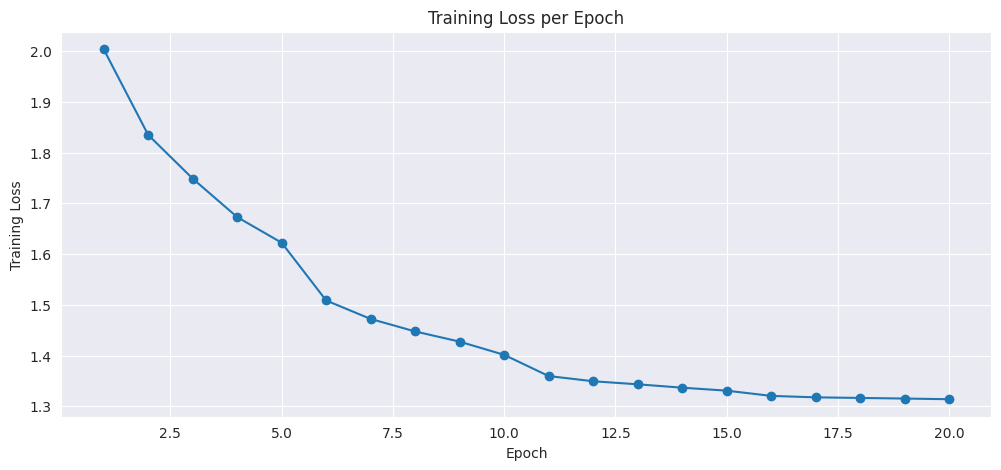

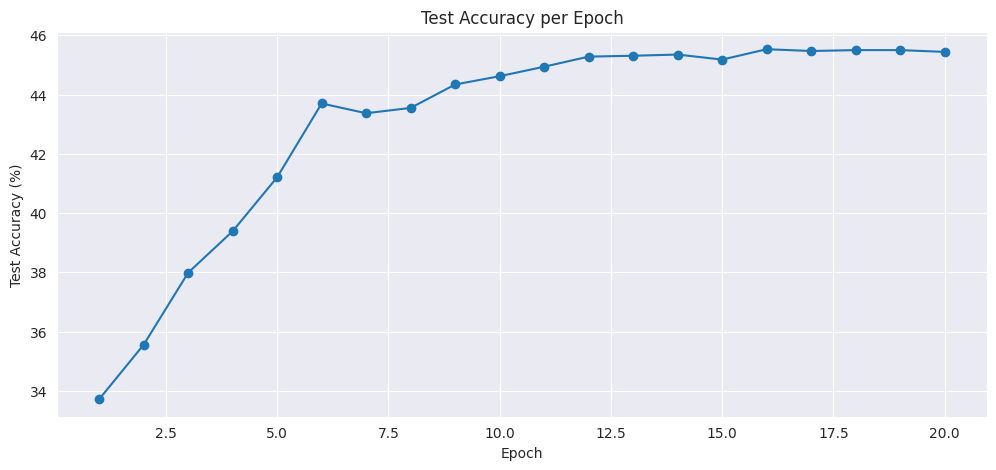

In [48]:
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), test_acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.show()


Evaluation Metrics:
Accuracy:  0.4544
Precision: 0.4516
Recall:    0.4544
F1 Score:  0.4515

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1000
           1       0.55      0.54      0.55      1000
           2       0.38      0.37      0.38      1000
           3       0.34      0.27      0.30      1000
           4       0.35      0.35      0.35      1000
           5       0.44      0.38      0.41      1000
           6       0.44      0.55      0.49      1000
           7       0.50      0.54      0.52      1000
           8       0.53      0.56      0.54      1000
           9       0.50      0.53      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



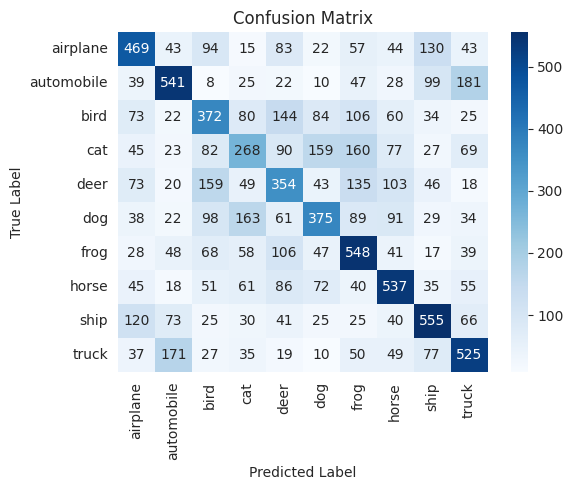

In [49]:
eval_model(model, test_loader_cifar, classes=classes, py_torch=True)

**Metrics Analysis**
   Overall, the model is correct about **45%** of the time—better than random guessing at 10%, but still leaving considerable scope for improvement. The **precision** (0.4477) and **recall** (0.4499) are almost identical, showing that the model does not disproportionately misclassify positive or negative cases at a class level, though it remains at a relatively modest level for both. The **F1 score** (0.4480), reflecting a balance of precision and recall, is in line with these figures.

   Looking at individual classes:
   - **Class 1 (Automobile)** has the highest precision and recall in this dataset, indicating that the model can differentiate certain vehicle shapes or features.
   - **Classes 2, 3, and 4 (Bird, Cat, Deer)** post lower values, suggesting significant confusion among visually similar animals.
   - **Class 8 (Ship)** achieves a stronger recall of 0.58, implying a relative ease in recognizing ship-like features once the model detects them.

   Both **macro** and **weighted averages** hover around 0.45, signaling that most classes are being predicted at about the same moderate level, rather than having a couple of outliers skew performance.

**Confusion Matrix Observations**
   A notable source of misclassification lies between **automobiles (row 1)** and **trucks (row 9)**. The model commonly swaps these two, likely because both are vehicles with boxy shapes or share similar environmental backgrounds, such as roads or parking areas.
   The confusion among **deer, cat, and dog** suggests that the network, when presented with flattened images, fails to latch onto the spatial distinctions that separate these animals—like body proportions, positioning of the head and limbs, or other subtle cues.

**Why Poor result**
   Since we are using ANN, This network flattens each 32×32 image into a 1D vector, effectively discarding **positional and local context** that would differentiate, for example, a truck bed versus a car trunk, or a cat’s ears versus a dog’s snout. Without spatial relationships, the model’s learned features fail to capture crucial visual details.

**Looking Forward: CNNs**
   In contrast, **convolutional neural networks** naturally exploit spatial patterns, weight-sharing, and local receptive fields to capture image-specific structures. In the upcoming assignment, applying a CNN to this same dataset will likely reduce confusion patterns substantially, improving metrics like accuracy, recall, and F1 across most classes.


#### Conclusion

Overall, the experiments clearly indicate that the combination of Adam with a moderate learning rate of 0.001 and a StepLR scheduler provided the best results. This setup allowed the model to benefit from both rapid initial learning and effective improvement later in the training process. While adaptive optimizers like Adam and RMSprop outperformed plain SGD, the scheduled reduction in the learning rate proved crucial for achieving optimal convergence. High learning rates led to instability, and very low rates slowed progress. Thus, balancing these hyperparameters is essential, and in this investigation, the Adam with StepLR configuration emerged as the most effective strategy.

In this assignment, the primary focus was on delving into the mathematical derivations that form the backbone of artificial neural networks (ANNs). Rather than showcasing an optimized training process or extensive exploratory analysis, my intent was to work through the fundamental principles—particularly matrix calculus—that underpin the operations of ANNs. Given the vast scope of ANN theory, it’s inevitable that some theoretical aspects may have been overlooked or could be expanded upon further. The foundation of ANNs is a rich and complex topic, and the theory can be integrated into many subtopics; however, for this assignment, I concentrated on the core mathematical derivations. This approach reflects my goal of deepening my understanding of the theoretical constructs behind neural networks, which is essential for advancing in ML engineering beyond simply applying pre-built frameworks to solve tasks.